In [2]:
import gzip
import numpy
import urllib
import scipy.optimize
import random
from collections import defaultdict
import matplotlib.pyplot as plt

try:
    from tqdm import tqdm_notebook
except:
    tqdm_notebook = lambda x: x # if not this package, just do nothing.

In [3]:
def readGz(f):
    for l in tqdm_notebook(gzip.open(f)):
        yield eval(l)

data = list(readGz("reviews_Electronics_5.json.gz"))

In [4]:
data[0]

{'reviewerID': 'AO94DHGC771SJ',
 'asin': '0528881469',
 'reviewerName': 'amazdnu',
 'helpful': [0, 0],
 'reviewText': 'We got this GPS for my husband who is an (OTR) over the road trucker.  Very Impressed with the shipping time, it arrived a few days earlier than expected...  within a week of use however it started freezing up... could of just been a glitch in that unit.  Worked great when it worked!  Will work great for the normal person as well but does have the "trucker" option. (the big truck routes - tells you when a scale is coming up ect...)  Love the bigger screen, the ease of use, the ease of putting addresses into memory.  Nothing really bad to say about the unit with the exception of it freezing which is probably one in a million and that\'s just my luck.  I contacted the seller and within minutes of my email I received a email back with instructions for an exchange! VERY impressed all the way around!',
 'overall': 5.0,
 'summary': 'Gotta have GPS!',
 'unixReviewTime': 13701

In [5]:
len(data)

1689188

In [6]:
train_data = data[:840000]
validation_data = data[840000:]

In [7]:
# Encode itemID and reviewerID
reviewerID_str = list(set([elmt['reviewerID'] for elmt in train_data]))
itemID_str = list(set([elmt['asin'] for elmt in train_data])) 
number_of_reviewers = len(reviewerID_str)
number_of_itemID = len(itemID_str)
reviewerIDs = dict(zip(reviewerID_str,range(number_of_reviewers))) 
itemIDs = dict(zip(itemID_str, range(number_of_itemID)))

In [8]:
R = numpy.zeros((number_of_reviewers,number_of_itemID))
reviewer_to_item = defaultdict(list)
item_to_reviewer = defaultdict(list)

for elmt in train_data:
    reviewerID = reviewerIDs[elmt['reviewerID']]
    itemID = itemIDs[elmt['asin']]
    R[reviewerID][itemID] = elmt['overall']
    reviewer_to_item[reviewerID].append(itemID)
    item_to_reviewer[itemID].append(reviewerID)

def compute_MSE(predictions,y):
    return numpy.dot((predictions-y),(predictions-y).T)/float(len(y))

def predict(elmt,beta_u, beta_i, alpha):
    try:
        reviewerID = reviewerIDs[elmt['reviewerID']]
        itemID = itemIDs[elmt['asin']]
        return alpha+beta_u[reviewerID]+beta_i[itemID]
    except:
        return alpha
    
def gradient_descent(x_train, beta_u, beta_i, alpha, lam_i=10, lam_u=15, iteration=2, y_validation=None):
    MSEs = []
    for _ in tqdm_notebook(range(iteration)):
        for j in range(len(x_train)):
            reviewerID,itemID = x_train[j]
            reviewer_items = reviewer_to_item[reviewerID]
            beta_u[reviewerID] = (R[reviewerID,reviewer_items].sum()-alpha*len(reviewer_items)-beta_i[reviewer_items].sum())/(lam_u+len(reviewer_items))
            item_reviewers = item_to_reviewer[itemID]
            beta_i[itemID] = (R[item_reviewers,itemID].sum()-alpha*len(item_reviewers)-beta_u[item_reviewers].sum())/(lam_i+len(item_reviewers))
        
        if y_validation is not None:
            predictions = [predict(elmt, beta_u, beta_i, alpha) for elmt in validation_data]
            MSE = compute_MSE(predictions, y_validation)
            MSEs.append(MSE)

    if MSEs:
        return alpha, beta_i, beta_u, MSEs
    return alpha, beta_i, beta_u

def features(elmt):
    reviewerID = elmt['reviewerID']
    itemID = elmt['asin']
    return [reviewerIDs[reviewerID],itemIDs[itemID]]
    

In [10]:
X = numpy.array([features(elmt) for elmt in train_data])
y = numpy.array([elmt['overall'] for elmt in train_data])
y_validation = numpy.array([elmt['overall'] for elmt in validation_data])
beta_u = numpy.random.random(number_of_reviewers)
beta_i = numpy.random.random(number_of_itemID)
alpha = numpy.mean(y)
alpha,beta_i,beta_u = gradient_descent(X,beta_u,beta_i,alpha,lam_i=1,lam_u=1)
predictions = [predict(elmt,beta_u,beta_i,alpha) for elmt in validation_data]
MSE = compute_MSE(predictions,y_validation)
print(MSE)


1.3544263656631608


In [11]:
# try different lam_i lam_u
alpha,beta_i,beta_u, MSEs = gradient_descent(X,beta_u,beta_i,alpha,lam_i=10, lam_u=15, iteration=10, y_validation)

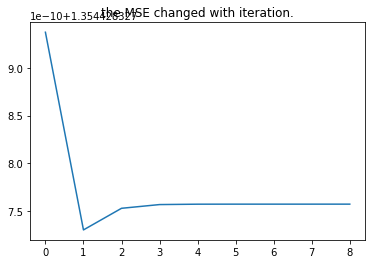

In [13]:
plt.plot(MSEs[1:10])
plt.title("the MSE changed with iteration.")
plt.show()

In [14]:
print("the mininum mse %f appear in %d-th iteration" % (min(MSEs), MSEs.index(min(MSEs))))

the mininum mse 1.354428 appear in 2-th iteration


1.3544262931438888